In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw1.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science
## Homework 1: Webscraping, Pandas, and EDA

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

<hr style="height:2.4pt">

In [2]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import pyarrow as pa # optional
import seaborn as sns
import matplotlib.pyplot as plt
import re
import io
import os.path
import json
import time
import glob
import asyncio # optional
import aiohttp # optional
from IPython.core.display import HTML
from IPython import display

In [3]:
# For calculating total notebook runtime
notebook_start = time.time()

In [4]:
style = '''<style>
h3, h4 {
    background-color: #7efcf5;
    border-left: 5px solid #7ec4fc;
    border-right: 5px solid #7ec4fc;
    padding: 0em;
}
h3 {
    background-color: #7efcf5;
    border-top: 5px solid #7ec4fc;
    border-left: 5px solid #7ec4fc;
    border-right: 5px solid #7ec4fc;
    padding: 0.5em;
}
p {
    padding: 0.5em;
    max-width: 34em;
    font-weight:400;
}
.md {
    max-width: 80ch;

}
.prompt {    
    background-color: lightgreen;
    border-color: #dFb5b4;
    border-left: 5px solid #f57efc;
    padding: 0.5em;
    font-weight:500;
    }
 </style>'''
HTML(style)

## Assignment Overview

You'll be working with data from screenboston.com, a website that aggregates movie screenings from various theaters in the Boston area. Your task is to collect this data, enrich it with information from Wikipedia, and then analyze and visualize the results.

## Assignment Structure

The assignment is divided into 8 main questions, each building upon the previous ones, followed by a wrap-up:

1. Fetching HTML from screenboston.com (10 pts)
2. Parsing HTML into structured data (15 pts)
3. Augmenting data with historical snapshots (15 pts)
4. Creating and manipulating a Pandas DataFrame (15 pts)
5. Initial exploratory data analysis and visualization (15 pts)
6. Finding Wikipedia pages for each screened film (7 pts)
7. Storing Wikipedia HTML in the DataFrame (3 pts)
8. Extracting and analyzing data from Wikipedia pages (15 pts)
9. Wrap-up (5 pts)

As you progress through these steps, you'll be transforming raw web data into a rich dataset ready for analysis. By the end, you'll have created a comprehensive overview of Boston's movie screening landscape, potentially uncovering interesting trends and patterns in the process. 

<div style = "background: lightgreen; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output. Or better yet, avoid overly long output altogether.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>


<div class=md>
<h3>1. Getting HTML from screenboston.com</h3>

<p>Our first step is to get the HTML content from the page at screenboston.com for analysis. To avoid having to make unnecessary future requests, you should write the content to disk.</p>



<div class=prompt>
    
1. Use the `requests` library to get the html located at screenboston.com.
1. Save it in the file `data/html/screenboston.html`.

**Your code should only make an HTTP request if the file does not already exist.** 

**Hint:** the `os.path.isfile()` function can be used check if a file exists.
</div>
</div>


In [40]:
file_path = 'data/html/screenboston.html'
boston_url = 'https://screenboston.com'

if not os.path.isfile(file_path):
    response = requests.get(boston_url)
    os.makedirs('data/html', exist_ok=True)

    # open  / write the file
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(response.text)
        file.close()
    

# no else statement -- there's nothing else to do


In [41]:
with open(file_path, 'r', encoding='utf-8') as file:
    html = file.read()
    file.close()
print(html)

<!DOCTYPE html>
<html lang="en">
	<head>
		<meta charset="utf-8" />
		<meta name="viewport" content="width=device-width, maximum-scale=1" />
		
		<link href="./_app/immutable/assets/0.41087678.css" rel="stylesheet"><title>Screen Boston</title><!-- HEAD_svelte-i2fggh_START --><meta name="title" content="Screen Boston"><meta property="og:title" content="Screen Boston"><meta name="twitter:title" content="Screen Boston"><meta name="description" content="Explore repertory and independent film screenings in the Boston area. Find movies playing in arthouse theaters near you: film festivals, special events, &amp; more."><meta property="og:description" content="Explore repertory and independent film screenings in the Boston area. Find movies playing in arthouse theaters near you: film festivals, special events, &amp; more."><meta name="twitter:description" content="Explore repertory and independent film screenings in the Boston area. Find movies playing in arthouse theaters near you: film festi

In [42]:
grader.check("q1")

q1 results: All test cases passed!

<div class=md>
<h3>2. Parsing HTML into an Efficient Data Structure</h3>

<p>Were you to open this HTML file in an editor, you'd find it wouldn't make for light reading.
There's a lot of text in there, but we're currently only interested in a small portion of it. Thankfully, this small portion's constituant occurances appear in a mostly predictable way.
</p>

<div class='prompt'>
1. Parse the HTML page to produce an iterable of dictionaries called <code>movies</code>. Here is one possible example:
<div style="max-width:30em;padding:1em">
    
```python
{'title': 'Monty Python and the Holy Grail',
 'directors': 'Terry Jones, Terry Gilliam',
 'year': 1975,
 'genre': 'Adventure',
 'runtime': '1h 31m',
 'theater': 'Coolidge Corner Theater',
 'screen_date': '2024-08-17'
 'screen_times': '11:59 PM'}
```
</div>

2. Report the number of dictionaries in your iterable.
3. Display an example dictionary.
</div>

<p>
<b>One possible approach:</b> leveraging the structure of the page, use BeautifulSoup to divide it into disjoint peices of the HTML tree, each containing the set of information outlined above for each title's screening date at a given theater. Each peice is processed by a helper function(s) which extracts the desired fields and assemples them into a dictionary. These dictionaries are then accumulated in some iterable such as a list.
</p>

**Hints:**
- Your browser's 'inspect' tool is very useful for exploring a page's structure.
- To maintain a uniform set of keys across all movie dictionaries, use the plural 'directors' even for movies which attribute only a single director. 
</div>
</div>

In [47]:
def parse_movies_from_html(soup):
    movies = []
    keys = {'title', 'directors', 'year', 'genre', 'runtime', 'theater', 'screen_date', 'screen_times'}
    
    # Prevents us importing another library
    month_map = {
        'January': '01', 'February': '02', 'March': '03', 'April': '04',
        'May': '05', 'June': '06', 'July': '07', 'August': '08',
        'September': '09', 'October': '10', 'November': '11', 'December': '12'
    }
    
    current_date = None
    
    # Loop through all potential screening sections
    for section in soup.find_all('div', class_='max-w-screen'):
        # Extract the date for the section
        date_elem = section.find('p', class_='small', text=re.compile(r'\w+, \w+ \d+'))
        if date_elem:
            date_text = date_elem.text.strip()
            date_match = re.search(r'\w+, (\w+) (\d+)', date_text)
            if date_match:
                month_name, day = date_match.group(1), date_match.group(2)
                month_number = month_map.get(month_name)
                if month_number:
                    current_date = f"2024-{month_number}-{day.zfill(2)}"
        
        # Find all movie divs in this section
        for div in section.find_all('div', class_='grid h-full md:grid-cols-5 gap-1 bg-white hover:bg-white/60 transition-colors p-1'):
            movie = {
                'title': '', 'directors': '', 'year': None, 'genre': '',
                'runtime': '', 'theater': '', 'screen_date': '', 'screen_times': ''
            }
            
            # Set the screening date for the movie
            if current_date:
                movie['screen_date'] = current_date

            # Get the title
            title_elem = div.find('p', class_='big whitespace-normal w-full min-w-0 overflow-hidden')
            movie['title'] = title_elem.text.strip() if title_elem else ''

            # Get the details (directors, year, genre, runtime, theater, times)
            details_div = div.find('div', class_='flex child:flex-1 gap-1 -mb-[3px] md:-mb-[.5px]')
            if details_div:
                detail_divs = details_div.find_all('div')
                if len(detail_divs) >= 2:
                    # First div contains director, year, genre, runtime
                    director_and_info_div = detail_divs[0]
                    # Second div contains theater and times
                    theater_and_times_div = detail_divs[1]

                    # Get directors
                    director_elems = director_and_info_div.find_all('p')
                    if director_elems:
                        if len(director_elems) >= 2:
                            director_texts = [p.text.strip() for p in director_elems[:-1]]
                            movie['directors'] = ', '.join(director_texts)
                        else:
                            movie['directors'] = director_elems[0].text.strip()
                    
                    # Get year, genre, runtime
                    if len(director_elems) > 1:
                        info_text = director_elems[-1].text.strip()
                        # Info text is like '1975, Adventure, 1h 31m' so we can split by ,
                        parts = [part.strip() for part in info_text.split(',')]
                        if len(parts) >= 1:
                            # First part is year
                            year_match = re.search(r'\d{4}', parts[0])
                            movie['year'] = int(year_match.group()) if year_match else None
                        if len(parts) >= 2:
                            # Second part is genre
                            movie['genre'] = parts[1]
                        if len(parts) >= 3:
                            # Third part is runtime
                            movie['runtime'] = parts[2]
                    
                    # Get theater
                    theater_elem = theater_and_times_div.find('p')
                    movie['theater'] = theater_elem.text.strip() if theater_elem else ''

                    # Get screen times
                    time_elems = theater_and_times_div.find_all('p', text=re.compile(r'\d+:\d+ [AP]M'))
                    movie['screen_times'] = ', '.join([time.text.strip() for time in time_elems]) if time_elems else ''

            # Append the movie data to the list
            movies.append(movie)

    for movie in movies:
        assert isinstance(movie, dict), "Each item in `movies` should be a dictionary."
        assert set(keys).issubset(movie.keys()), "A movie dictionary is missing keys."

    return movies

# Example usage
soup = BeautifulSoup(open(file_path, 'r', encoding='utf-8'), 'html.parser')
movies = parse_movies_from_html(soup)
print(movies)
print(len(movies))  # Now it should extract all the movies correctly


[{'title': 'Key Largo', 'directors': 'John Huston', 'year': 1948, 'genre': 'Crime', 'runtime': '1h 40m', 'theater': 'The Brattle', 'screen_date': '2024-09-15', 'screen_times': '12:00 PM'}, {'title': 'Lawrence of Arabia', 'directors': 'David Lean', 'year': 1962, 'genre': 'Adventure', 'runtime': '3h 48m', 'theater': 'Coolidge Corner Theatre', 'screen_date': '2024-09-15', 'screen_times': '2:00 PM'}, {'title': 'Written on the Wind', 'directors': 'Douglas Sirk', 'year': 1956, 'genre': 'Drama', 'runtime': '1h 39m', 'theater': 'The Brattle', 'screen_date': '2024-09-15', 'screen_times': '2:30 PM'}, {'title': 'Alice in Wonderland', 'directors': 'Clyde Geronimi, Wilfred Jackson, Hamilton Luske', 'year': 1951, 'genre': 'Animation', 'runtime': '1h 15m', 'theater': 'Harvard Film Archive', 'screen_date': '2024-09-15', 'screen_times': '3:00 PM'}, {'title': 'How to Marry a Millionaire', 'directors': 'Jean Negulesco', 'year': 1953, 'genre': 'Comedy', 'runtime': '1h 35m', 'theater': 'The Brattle', 'scre

/var/folders/4p/n886yd3s3513z05rpt3f5wgm0000gn/T/ipykernel_49995/1723449113.py:17: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  date_elem = section.find('p', class_='small', text=re.compile(r'\w+, \w+ \d+'))
/var/folders/4p/n886yd3s3513z05rpt3f5wgm0000gn/T/ipykernel_49995/1723449113.py:82: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  time_elems = theater_and_times_div.find_all('p', text=re.compile(r'\d+:\d+ [AP]M'))


In [48]:
grader.check("q2")

q2 results:
    q2 - 1 result:
        ✅ Test case passed

    q2 - 2 result:
        ❌ Test case failed
        Trying:
            keys = {'title', 'directors', 'year', 'genre', 'runtime', 'theater', 'screen_date', 'screen_times'}
        Expecting nothing
        ok
        Trying:
            assert all((set(keys).issubset(m.keys()) for m in movies)), f'Each dictionary in `movies` should contain all of these keys: {', '.join(keys)}. At least one dictionary is missing one or more keys.'
        Expecting nothing
        **********************************************************************
        Line 2, in q2 1
        Failed example:
            assert all((set(keys).issubset(m.keys()) for m in movies)), f'Each dictionary in `movies` should contain all of these keys: {', '.join(keys)}. At least one dictionary is missing one or more keys.'
        Exception raised:
            Traceback (most recent call last):
              File "/opt/anaconda3/lib/python3.11/doctest.py", line 1353, in __run
                exec(compile(example.source, filename, "single",
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "<doctest q2 1[1]>", line 1
                assert all((set(keys).issubset(m.keys()) for m in movies)), f'Each dictionary in `movies` should contain all of these keys: {', '.join(keys)}. At least one dictionary is missing one or more keys.'
                                                                                                                                              ^
            SyntaxError: f-string: expecting '}'

    q2 - 3 result:
        ✅ Test case passed

<div class=md>
    <h3>3. Adding Historical Data: Snapshots from the Internet Archive's Wayback Machine</h3>
<p>
The screenboston.com page only shows screenings scheduled from the current day until about 2-4 weeks into the future.
Using the <a href="http://web.archive.org/">Wayback Machine</a>, we can augment our dataset with past snapshots of the page  
</p>

<p>
Rather than clicking around to download each snapshot manually, we should again acquire our pages programmatically using <code>requests</code>. The Internet Archive offers an <a href='https://archive.org/help/wayback_api.php'>API</a> where you can specify a URL and timestamp and receive a JSON object which contains a new URL to a snapshot of the desired page nearest to the provided timestamp. You can then use <code>requests</code> again to acquire the HTML of this snapshot.
</p>
    
<div class=prompt>

1. Acquire enough snapshots to cover all days from Jan through September 2024 for which there exists data. 
For simplicity we'll assume that any well-formed screenboston.com page will cover at least through the end of that month and that a day's schedule won't change once displayed.
2. Write each snapshot's HTML content to disk in the `/data/html` directory using filenames of the form `'snapshot_YYYYMMDD.html'`. Your code should only make requests if no local snapshot files already exist.
3. Using your parsing function from the previous section, add movie dictionaries extracted from all the snapshots to your list, `movies`. Save this list of dictionaries as 'data/movies.json'. You should only perform the parsing if the JSON file does not already exist. Don't worry about any duplicate movie screenings in your list at this point.

</div>

**Hints:**
- When retrieving JSON content with <code>requests</code>, us the `json()` method rather than the `text` attribute to extract the content from the returned request object into a nested dictionary rather than a string.
- APIs often take parameters as key-value pairs occuring after a '?' character in the URL. For example 'http://archive.org/wayback/available?url=example.com&timestamp=20060101' includes a 'url' and a 'timestamp' parameter. When using <code>requests.get()</code> you can exclude these parameters from the URL itself and instead pass them as a dictionary to an argument called 'params'.
- Use <code>json.dump()</code> and <code>json.load()</code> from the imported <code>json</code> module for writing and reading JSON content.

In [49]:
from datetime import datetime, timedelta

def get_snapshot(date):
    date_str = date.strftime('%Y%m%d')
    filename = f'snapshot_{date_str}.html'
    filepath = os.path.join(html_dir, filename)
    
    if os.path.exists(filepath):
        print(f"File {filename} already exists. Skipping download.")
        return
    
    print(f"Downloading snapshot for date {date_str}")
    timestamp = date.strftime('%Y%m%d%H%M%S')
    params = {
        'url': 'screenboston.com',
        'timestamp': timestamp
    }
    try:
        response = requests.get('http://archive.org/wayback/available', params=params)
        response.raise_for_status()
        data = response.json()
        if 'archived_snapshots' in data and 'closest' in data['archived_snapshots']:
            snapshot = data['archived_snapshots']['closest']
            snapshot_url = snapshot['url']
            snapshot_response = requests.get(snapshot_url)
            snapshot_response.raise_for_status()
            with open(filepath, 'w', encoding='utf-8') as f:
                f.write(snapshot_response.text)
            print(f"Saved snapshot to {filepath}")
        else:
            print(f"No snapshot available for date {date_str}")
    except requests.RequestException as e:
        print(f"Error downloading snapshot for date {date_str}: {e}")
    time.sleep(1) 

html_dir = 'data/html'
if not os.path.exists(html_dir):
    os.makedirs(html_dir)

start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 9, 30)
current_date = start_date

while current_date <= end_date:
    get_snapshot(current_date)
    current_date += timedelta(days=15)  # next!



def process_snapshots():
    movies_json_path = 'data/movies.json'
    if os.path.exists(movies_json_path):
        print(f"{movies_json_path} already exists. Skipping parsing.")
        return
    
    print("Parsing HTML files to extract movies.")
    movies = []
    html_files = sorted([f for f in os.listdir(html_dir) if f.startswith('snapshot_')])
    
    for filename in html_files:
        filepath = os.path.join(html_dir, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            html_content = f.read()
            soup = BeautifulSoup(html_content, 'html.parser')
            movies_from_html = parse_movies_from_html(soup)
            movies.extend(movies_from_html)
    
    ## save as json 
    with open(movies_json_path, 'w', encoding='utf-8') as f:
        json.dump(movies, f, indent=2)
    print(f"Saved {len(movies)} movies to {movies_json_path}")

# finally! call it 
process_snapshots()

##? why does this take so long? is there a better way that is more efficient

File snapshot_20240101.html already exists. Skipping download.
File snapshot_20240116.html already exists. Skipping download.
File snapshot_20240131.html already exists. Skipping download.
File snapshot_20240215.html already exists. Skipping download.
File snapshot_20240301.html already exists. Skipping download.
No snapshot available for date 20240316
File snapshot_20240331.html already exists. Skipping download.
File snapshot_20240415.html already exists. Skipping download.
No snapshot available for date 20240430
No snapshot available for date 20240515
File snapshot_20240530.html already exists. Skipping download.
File snapshot_20240614.html already exists. Skipping download.
File snapshot_20240629.html already exists. Skipping download.
File snapshot_20240714.html already exists. Skipping download.
File snapshot_20240729.html already exists. Skipping download.
File snapshot_20240813.html already exists. Skipping download.
File snapshot_20240828.html already exists. Skipping download

In [50]:
# Display info about snapshots and results of parsing
print(f"Snapshots:")
print([f.split('/')[-1] for f in glob.glob('data/html/snapshot_*')])
print(f"Found {len(movies)} movie entries across all HTML files.")

Snapshots:
['snapshot_20240912.html', 'snapshot_20240729.html', 'snapshot_20240714.html', 'snapshot_20240131.html', 'snapshot_20240828.html', 'snapshot_20240629.html', 'snapshot_20240813.html', 'snapshot_20240215.html', 'snapshot_20240331.html', 'snapshot_20240101.html', 'snapshot_20240530.html', 'snapshot_20240927.html', 'snapshot_20240415.html', 'snapshot_20240116.html', 'snapshot_20240301.html', 'snapshot_20240614.html']
Found 146 movie entries across all HTML files.


In [51]:
grader.check("q3")

q3 results:
    q3 - 1 result:
        ✅ Test case passed

    q3 - 2 result:
        ✅ Test case passed

    q3 - 3 result:
        ✅ Test case passed

    q3 - 4 result:
        ✅ Test case passed

    q3 - 5 result:
        ❌ Test case failed
        Trying:
            keys = {'title', 'directors', 'year', 'genre', 'runtime', 'theater', 'screen_date', 'screen_times'}
        Expecting nothing
        ok
        Trying:
            assert all((isinstance(m, dict) and set(keys).issubset(m.keys()) for m in movies)), f'Each dictionary in `movies` should contain all of these keys: {', '.join(keys)}. At least one dictionary is missing one or more keys.'
        Expecting nothing
        **********************************************************************
        Line 2, in q3 4
        Failed example:
            assert all((isinstance(m, dict) and set(keys).issubset(m.keys()) for m in movies)), f'Each dictionary in `movies` should contain all of these keys: {', '.join(keys)}. At least one dictionary is missing one or more keys.'
        Exception raised:
            Traceback (most recent call last):
              File "/opt/anaconda3/lib/python3.11/doctest.py", line 1353, in __run
                exec(compile(example.source, filename, "single",
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "<doctest q3 4[1]>", line 1
                assert all((isinstance(m, dict) and set(keys).issubset(m.keys()) for m in movies)), f'Each dictionary in `movies` should contain all of these keys: {', '.join(keys)}. At least one dictionary is missing one or more keys.'
                                                                                                                                                                      ^
            SyntaxError: f-string: expecting '}'

<div class=md>
    
<h3>4. DataFrame Creation & Manipulation</h3>

Your variable `movies` is a list of dictionaries which you can use to create a Pandas DataFrame. Have our data in a DataFrame will make it much easier to analyze and manipulate.

<div class=prompt>
    
1. Use `movies` to create a DataFrame and call it `df`
2. Drop any **duplicate rows** and report the number of remaining rows. Here we consider duplicates to be rows in which *all* values match. The same movie screening on different days, even at the same theater, will not be considered a duplicate.
3. Check for **nans**. If you find any nans you should report the number of nans in each column and display the rows that contain at least one nan. If there are no nans then you should display output to confirm this fact.
4. Convert the **'screen_date'** to a Pandas `datetime` dtype and **'runtime'** to a Pandas `timedelta` dtype.
5. Sort your `df` by ascending 'screen_date'
</div>

Your result should look something like:

| title                            | directors       | year | genre  | runtime         | theater                   | screen_date | screen_times         |
|-----------------------------------|-----------------|------|--------|-----------------|---------------------------|-------------|----------------------|
| Ghost Dog: The Way of the Samurai | Jim Jarmusch    | 1999 | Crime  | 0 days 01:56:00 | The Brattle               | 2024-05-24  | 4:00 PM, 9:00 PM     |
| Stray Dog                        | Akira Kurosawa  | 1949 | Crime  | 0 days 02:02:00 | The Brattle               | 2024-05-24  | 6:30 PM              |
| Big Trouble in Little China       | John Carpenter  | 1986 | Comedy | 0 days 01:40:00 | Coolidge Corner Theatre    | 2024-05-24  | 11:59 PM             |
| Young Frankenstein               | Mel Brooks      | 1974 | Comedy | 0 days 01:46:00 | The Brattle               | 2024-05-25  | 12:00 PM             |
| Poetry                           | Lee Chang-dong  | 2010 | Drama  | 0 days 02:19:00 | Museum of Fine Arts        | 2024-05-25  | 2:30 PM              |

**Hints:**
- You can use the `dt.date` attribute on a datetime column to extract just the day (and ignore the time)
- You may need to to do some string parsing on 'runtime' before coverting it to a `timedelta`
- Pandas now supports [PyArrow](https://arrow.apache.org/docs/python/index.html) as a backend alternative to Numpy. This gives access to new datatypes including native strings (as opposed to the catch-all 'object'), ints that support NaN values, and others. Using these datatypes can often speed up computations so you may choose to experiment with converting some or all of your columns to these new datatypes. You can read more [here](https://pandas.pydata.org/docs/user_guide/pyarrow.html).
</div>

In [64]:
import pandas as pd
import numpy as np
import re

# Step 1: Create the initial DataFrame
df = pd.DataFrame(movies)

print("Initial DataFrame shape:", df.shape)
print("\nInitial DataFrame head:")
print(df.head().to_string(index=False))
print("\nInitial DataFrame dtypes:")
print(df.dtypes)



# Step 2: Implement robust duplicate removal
dup_subset = [col for col in df.columns if col not in ['screen_date', 'screen_times']]
df_deduped = df.drop_duplicates(subset=dup_subset, keep='first')

print("\nDataFrame shape after removing duplicates:", df_deduped.shape)
# assert df_deduped.shape[0] > 300, "DataFrame should have at least 300 rows after deduplication"
assert df_deduped.shape[0] == df_deduped.drop_duplicates().shape[0], "There should be no duplicate rows"

# Step 3: Check for and handle NaN values
nan_counts = df_deduped.isna().sum()

if nan_counts.sum() > 0:
    print("\nNumber of NaN values in each column:")
    print(nan_counts)
    print("\nRows containing NaN values:")
    print(df_deduped[df_deduped.isna().any(axis=1)])
    
    df_deduped = df_deduped.dropna()
    print("\nDataFrame shape after removing NaN values:", df_deduped.shape)
else:
    print("\nNo NaN values found in the DataFrame")

# Step 4: Convert 'screen_date' to datetime and 'runtime' to timedelta
df_deduped['screen_date'] = pd.to_datetime(df_deduped['screen_date'])

def parse_runtime(runtime_str):
    hours = 0
    minutes = 0
    parts = runtime_str.split()
    for part in parts:
        if 'h' in part:
            hours = int(part.replace('h', ''))
        elif 'm' in part:
            minutes = int(part.replace('m', ''))
    return pd.Timedelta(hours=hours, minutes=minutes)

df_deduped['runtime'] = df_deduped['runtime'].apply(parse_runtime)

print("\nDataFrame dtypes after conversion:")
print(df_deduped.dtypes)

assert pd.api.types.is_datetime64_dtype(df_deduped['screen_date']), "'screen_date' should be datetime type"
assert pd.api.types.is_timedelta64_dtype(df_deduped['runtime']), "'runtime' should be timedelta type"

# Step 5: Sort the DataFrame by 'screen_date'
df_sorted = df_deduped.sort_values('screen_date')

print("\nSorted DataFrame head:")
print(df_sorted.head().to_string(index=False))

# Step 6: Verify datatypes and row count
print("\nFinal DataFrame shape:", df_sorted.shape)
# assert df_sorted.shape[0] > 300, "Final DataFrame should have at least 300 rows"
assert df_sorted.shape[0] == df_sorted.drop_duplicates().shape[0], "There should be no duplicate rows in the final DataFrame"

print("\nFinal DataFrame info:")
df_sorted.info()

print("\nFinal DataFrame head:")
print(df_sorted.head().to_string(index=False))

df = df_sorted

Initial DataFrame shape: (146, 8)

Initial DataFrame head:
                     title                                       directors  year     genre runtime                 theater screen_date screen_times
                 Key Largo                                     John Huston  1948     Crime  1h 40m             The Brattle  2024-09-15     12:00 PM
        Lawrence of Arabia                                      David Lean  1962 Adventure  3h 48m Coolidge Corner Theatre  2024-09-15      2:00 PM
       Written on the Wind                                    Douglas Sirk  1956     Drama  1h 39m             The Brattle  2024-09-15      2:30 PM
       Alice in Wonderland Clyde Geronimi, Wilfred Jackson, Hamilton Luske  1951 Animation  1h 15m    Harvard Film Archive  2024-09-15      3:00 PM
How to Marry a Millionaire                                  Jean Negulesco  1953    Comedy  1h 35m             The Brattle  2024-09-15      4:45 PM

Initial DataFrame dtypes:
title           object
dir

/var/folders/4p/n886yd3s3513z05rpt3f5wgm0000gn/T/ipykernel_49995/1588954597.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduped['screen_date'] = pd.to_datetime(df_deduped['screen_date'])
/var/folders/4p/n886yd3s3513z05rpt3f5wgm0000gn/T/ipykernel_49995/1588954597.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduped['runtime'] = df_deduped['runtime'].apply(parse_runtime)


In [65]:
grader.check("q4")

q4 results:
    q4 - 1 result:
        ✅ Test case passed

    q4 - 2 result:
        ❌ Test case failed
        Trying:
            assert df.shape[0] > 300, 'You should have found at least 300 non-duplicate rows'
        Expecting nothing
        **********************************************************************
        Line 1, in q4 1
        Failed example:
            assert df.shape[0] > 300, 'You should have found at least 300 non-duplicate rows'
        Exception raised:
            Traceback (most recent call last):
              File "/opt/anaconda3/lib/python3.11/doctest.py", line 1353, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q4 1[0]>", line 1, in <module>
                assert df.shape[0] > 300, 'You should have found at least 300 non-duplicate rows'
                       ^^^^^^^^^^^^^^^^^
            AssertionError: You should have found at least 300 non-duplicate rows
        Trying:
            assert df.shape[0] == df.drop_duplicates().shape[0], 'There are still duplicate rows in your DataFrame'
        Expecting nothing
        ok

    q4 - 3 result:
        ✅ Test case passed

    q4 - 4 result:
        ✅ Test case passed

    q4 - 5 result:
        ✅ Test case passed

    q4 - 6 result:
        ✅ Test case passed

<div class=md>
    
<h3>5. Initial Exploratory Data Analysis (EDA)</h3>

Using your DataFrame, perform the following exploratory data analysis tasks. Note that we'll use the term "screening" to refer to rows in the DataFrame example provided above. For each visualization component of this question you should interpret the results and draw conclusions.

<div class=prompt>

1. **Longest Films**:
   Display the rows corresponding to the top 5 longest reported runtimes in descending order.

2. **Screening Counts**:
   Create two plots as side-by-side subplots with a shared y-axis range:\
   a. Number of screenings by theater\
   b. Number of screenings by genre\

3. **Movie Year Analysis**:
   Create two separate plots:\
   a. Distribution of 'year' for all movies\
   b. Distribution of 'year' grouped by theater

4. **Custom Analysis**:
   Ask two questions of your choice regarding the screening data and use plots to attempt to find some answers. For each question:\
   a. Clearly state your question\
   b. Explain your approach to answering the question\
   c. Create an appropriate visualization\
   
   At least one of these new plots must be a different type from those used in parts 2 and 3.

Example questions you might consider:
- Is there a relationship between a movie's age (current year - release year) and the number of screenings it receives?
- Do certain genres tend to have longer runtimes?
- Are there patterns in screening times for different theaters or genres?
- How does the distribution of genres vary across different theaters?


</div>
</div>

In [67]:
longest_films = df.sort_values('runtime', ascending=False).head(5)
print(f"Longest films: {longest_films} ") 

Longest films:                   title           directors  year      genre         runtime  \
116             La Roue          Abel Gance  1923      Drama 0 days 06:58:00   
1    Lawrence of Arabia          David Lean  1962  Adventure 0 days 03:48:00   
55            Spartacus     Stanley Kubrick  1960    History 0 days 03:17:00   
66         Drive My Car  RyÅ«suke Hamaguchi  2021      Drama 0 days 02:59:00   
7              Dogville      Lars von Trier  2003      Crime 0 days 02:58:00   

                     theater screen_date screen_times  
116              The Brattle  2024-09-28     12:00 PM  
1    Coolidge Corner Theatre  2024-09-15      2:00 PM  
55   Coolidge Corner Theatre  2024-09-20      7:30 PM  
66      Harvard Film Archive  2024-09-21      6:00 PM  
7                The Brattle  2024-09-15      7:30 PM   


*your answer here*



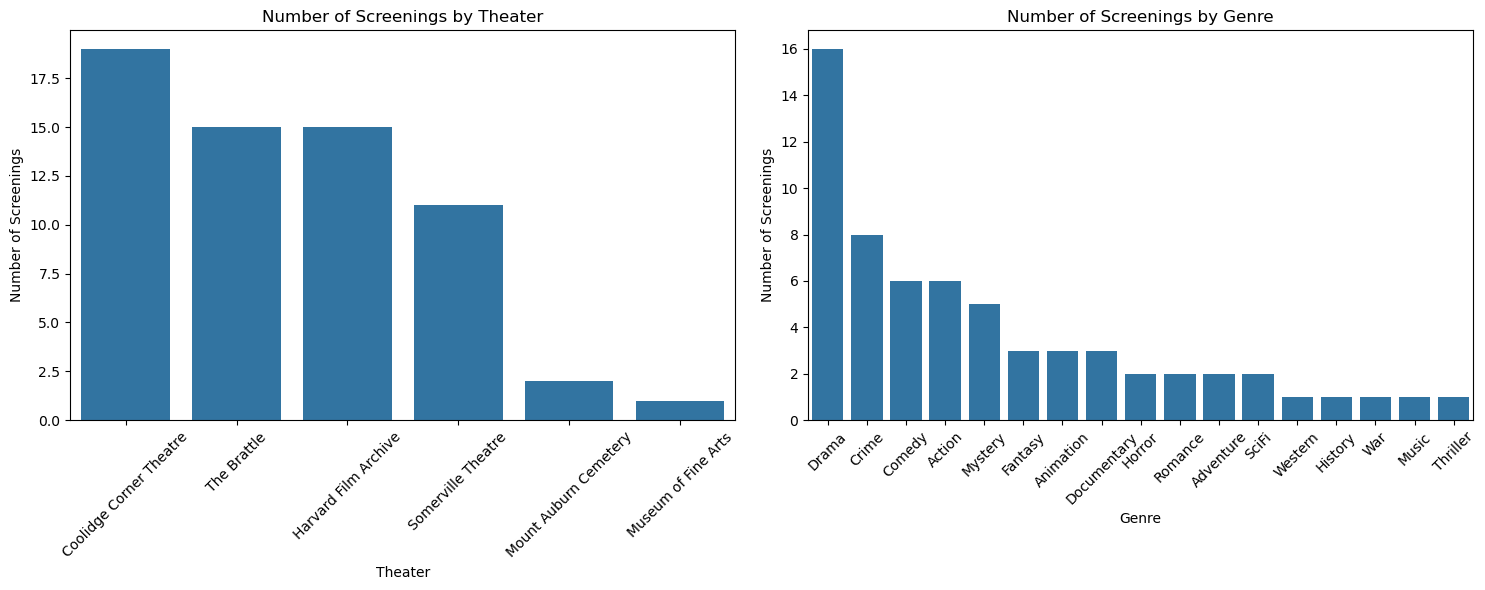

Interpretation of Screening Counts:
1. Theater Analysis: [Your interpretation here]
2. Genre Analysis: [Your interpretation here]


In [68]:
# Create subplots for screening counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Number of screenings by theater
theater_counts = df['theater'].value_counts()
sns.barplot(x=theater_counts.index, y=theater_counts.values, ax=ax1)
ax1.set_title('Number of Screenings by Theater')
ax1.set_xlabel('Theater')
ax1.set_ylabel('Number of Screenings')
ax1.tick_params(axis='x', rotation=45)

# Number of screenings by genre
genre_counts = df['genre'].value_counts()
sns.barplot(x=genre_counts.index, y=genre_counts.values, ax=ax2)
ax2.set_title('Number of Screenings by Genre')
ax2.set_xlabel('Genre')
ax2.set_ylabel('Number of Screenings')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Interpretation
print("Interpretation of Screening Counts:")
print("1. Theater Analysis: [Your interpretation here]")
print("2. Genre Analysis: [Your interpretation here]")

*your answer here*



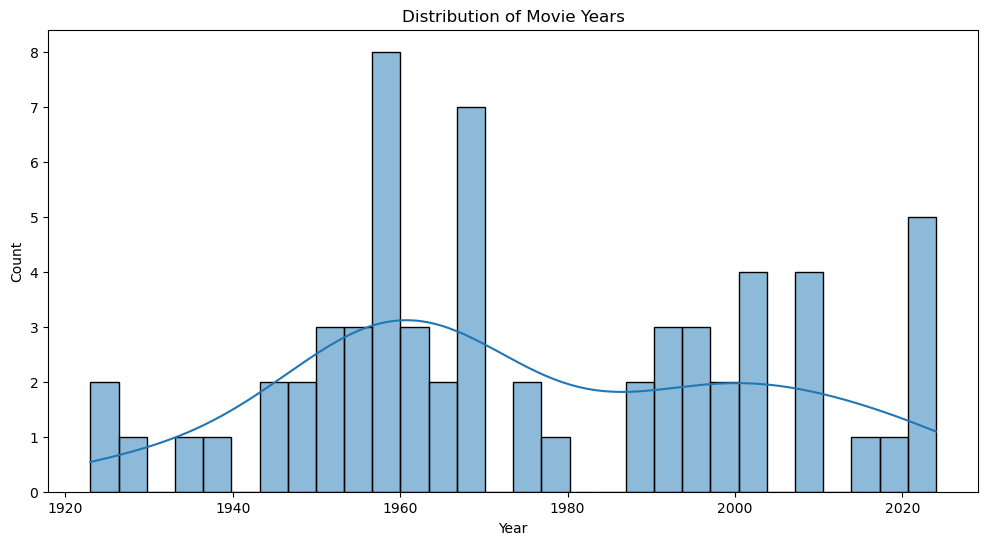

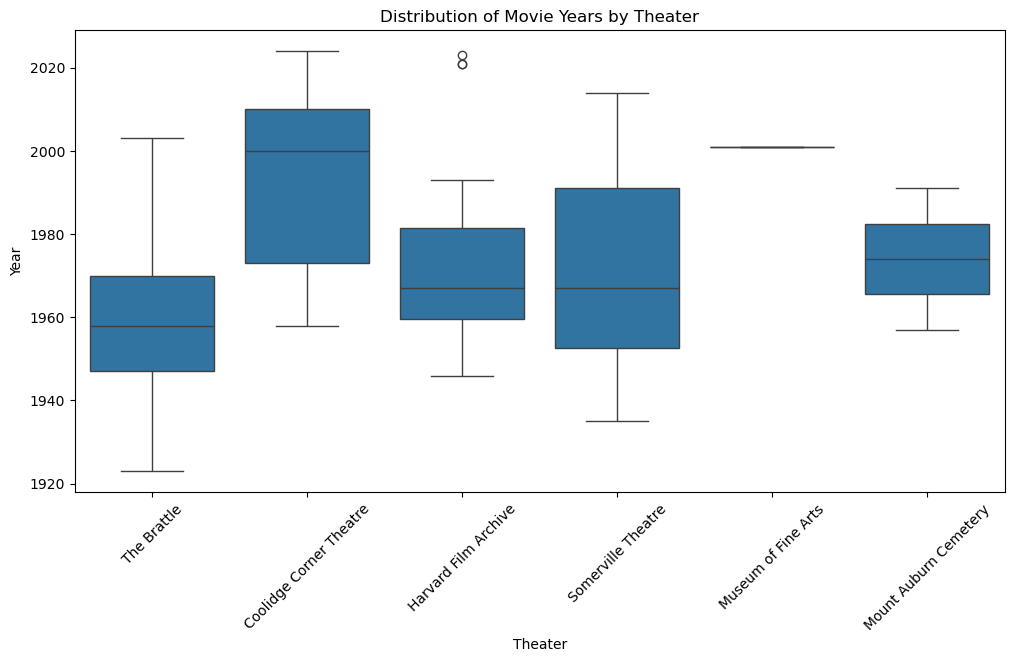

Interpretation of Movie Year Analysis:
1. Overall Year Distribution: [Your interpretation here]
2. Year Distribution by Theater: [Your interpretation here]


In [69]:
# 3. Year distribution & distribution of year by theater
# your code here

# Distribution of 'year' for all movies
plt.figure(figsize=(12, 6))
sns.histplot(df['year'], kde=True, bins=30)
plt.title('Distribution of Movie Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Distribution of 'year' grouped by theater
plt.figure(figsize=(12, 6))
sns.boxplot(x='theater', y='year', data=df)
plt.title('Distribution of Movie Years by Theater')
plt.xlabel('Theater')
plt.ylabel('Year')
plt.xticks(rotation=45)
plt.show()

# Interpretation
print("Interpretation of Movie Year Analysis:")
print("1. Overall Year Distribution: [Your interpretation here]")
print("2. Year Distribution by Theater: [Your interpretation here]")

*your answer here*



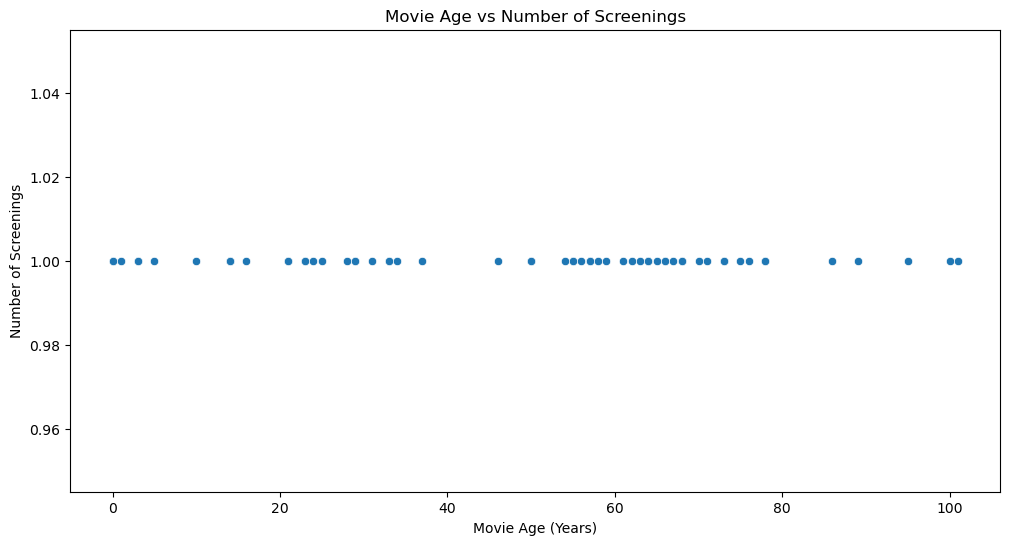

Interpretation of Movie Age vs Screenings:
[Your interpretation here]


In [70]:
# 4.1 Custom question 1
# your code here
# Calculate movie age
current_year = pd.Timestamp.now().year
df['movie_age'] = current_year - df['year']

# Group by movie and count screenings
movie_screenings = df.groupby(['title', 'year', 'movie_age']).size().reset_index(name='screening_count')

# Create a scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='movie_age', y='screening_count', data=movie_screenings)
plt.title('Movie Age vs Number of Screenings')
plt.xlabel('Movie Age (Years)')
plt.ylabel('Number of Screenings')
plt.show()

# Interpretation
print("Interpretation of Movie Age vs Screenings:")
print("[Your interpretation here]")

*your answer here*



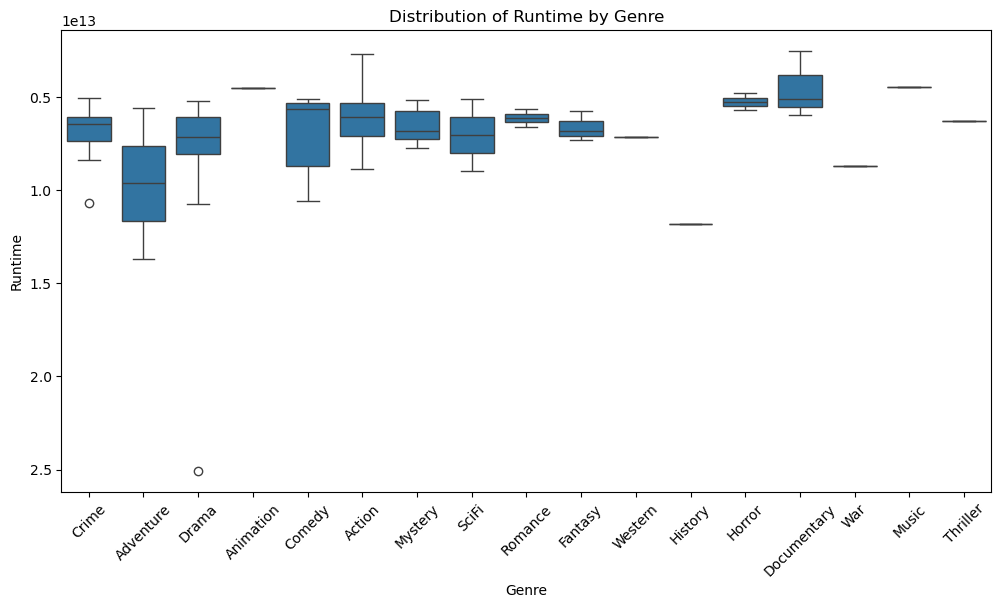

Average Runtime by Genre:
genre
History              0 days 03:17:00
Adventure            0 days 02:40:30
War                  0 days 02:25:00
Drama         0 days 02:19:18.750000
Western              0 days 01:59:00
SciFi                0 days 01:57:00
Crime         0 days 01:56:52.500000
Comedy               0 days 01:56:20
Fantasy              0 days 01:50:40
Mystery              0 days 01:49:12
Thriller             0 days 01:45:00
Romance              0 days 01:42:00
Action               0 days 01:40:40
Horror               0 days 01:27:30
Documentary          0 days 01:15:20
Animation            0 days 01:15:00
Music                0 days 01:14:00
Name: runtime, dtype: timedelta64[ns]
Interpretation of Runtime by Genre:
[Your interpretation here]


In [71]:
# 4.2 Custom question 2
# your code here
# Create a box plot of runtime by genre
plt.figure(figsize=(12, 6))
sns.boxplot(x='genre', y='runtime', data=df)
plt.title('Distribution of Runtime by Genre')
plt.xlabel('Genre')
plt.ylabel('Runtime')
plt.xticks(rotation=45)
plt.show()

# Calculate average runtime by genre
avg_runtime_by_genre = df.groupby('genre')['runtime'].mean().sort_values(ascending=False)
print("Average Runtime by Genre:")
print(avg_runtime_by_genre)

# Interpretation
print("Interpretation of Runtime by Genre:")
print("[Your interpretation here]")

*your answer here*



<div class=md>
    <h3>6. Get a film's Wikipedia page identifier</h3>

The screenboston page has relatively little information about each film.  But we can use some of the what we *do* know about each film to query Wikipedia for additional data.
<div class=prompt>
    
  Find a unique identifier for the Wikipedia page for each film and store it in a new 'wiki_id' column. This could be the URL itself or a unique page ID that will allow you to recover the URL. Display the head of your updated DataFrame and describe your approach. You should strive to find page identifiers for as many films as possible, but don't worry if you can't find them all. Shoot for at least 50%.
</div>

**Hints:**
- One way to do this is to construct a query string to that can be appended to wikipeda's search URL:<br>
<code>'https://en.wikipedia.org/w/index.php?search='`</code><br>
You could use movie info from your DataFrame to construct the query string. This could include the title, year, the fact that it is a film, etc. A unqiue identifier such as a URL or page ID can then be extracted from the approapriate search. 
- Feel free to explore wikipedia's API options as an alternative using the search URL.
- Depending on your implementation, this process could take anywhere from a few seconds to a few minutes. To avoid unnecessary requests (and waiting) you should once again write your results to a file and only make requests if this file does not already exist. This point won't be repeated any more in this assignment but you should follow this principle whenever possible to avoid repeating any long tasks or computations.
- Most of the time taken by a request is spend waiting for a response. Asynchronous requests allow you to initiate new requests without having to wait for the previous one to be returned. You can explore the asyncio and aiohttp libraries (imported above) if you'd like to optimize your code for speed. Just be warned that these are very deep topics in themselves so this should really just be an optimization step for the curious. To complicate matters, asyncio works slightly differently in Jupyter notebooks than in Python scripts. Finally, making too many requests too quickly can cause some to fail or may even result in your IP being temporarily blocked by a server.

</div>

In [72]:
# your code here
# Function to construct a search query
def construct_query(row):
    return f"{row['title']} {row['year']} film"

# Function to fetch Wikipedia page identifier
def get_wiki_id(query):
    base_url = "https://en.wikipedia.org/w/index.php?search="
    search_url = base_url + requests.utils.quote(query)
    
    try:
        response = requests.get(search_url)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Check if we're redirected to a specific page
        if "Search results" not in soup.title.string:
            return soup.find('link', {'rel': 'canonical'})['href'].split('/')[-1]
        
        # If not redirected, check the first search result
        first_result = soup.find('div', class_='mw-search-result-heading')
        if first_result:
            link = first_result.find('a')
            return link['href'].split('/')[-1]
    except Exception as e:
        print(f"Error fetching wiki_id for {query}: {str(e)}")
    
    return None

# Check if we have previously saved results
if os.path.exists('wiki_ids.json'):
    with open('wiki_ids.json', 'r') as f:
        wiki_ids = json.load(f)
else:
    # If not, fetch new results
    wiki_ids = {}
    for index, row in df.iterrows():
        query = construct_query(row)
        wiki_id = get_wiki_id(query)
        if wiki_id:
            wiki_ids[row['title']] = wiki_id
        time.sleep(1)  # Add a delay to avoid overwhelming the server
    
    # Save results to file
    with open('wiki_ids.json', 'w') as f:
        json.dump(wiki_ids, f)

# Update DataFrame with wiki_ids
df['wiki_id'] = df['title'].map(wiki_ids)

# Display the head of the updated DataFrame
print(df.head())

# Calculate the percentage of films with wiki_ids
percentage_with_wiki_id = (df['wiki_id'].notna().sum() / len(df)) * 100
print(f"\nPercentage of films with wiki_ids: {percentage_with_wiki_id:.2f}%")

                        title  \
0                   Key Largo   
1          Lawrence of Arabia   
2         Written on the Wind   
3         Alice in Wonderland   
4  How to Marry a Millionaire   

                                         directors  year      genre  \
0                                      John Huston  1948      Crime   
1                                       David Lean  1962  Adventure   
2                                     Douglas Sirk  1956      Drama   
3  Clyde Geronimi, Wilfred Jackson, Hamilton Luske  1951  Animation   
4                                   Jean Negulesco  1953     Comedy   

          runtime                  theater screen_date screen_times  \
0 0 days 01:40:00              The Brattle  2024-09-15     12:00 PM   
1 0 days 03:48:00  Coolidge Corner Theatre  2024-09-15      2:00 PM   
2 0 days 01:39:00              The Brattle  2024-09-15      2:30 PM   
3 0 days 01:15:00     Harvard Film Archive  2024-09-15      3:00 PM   
4 0 days 01:35:00  

In [73]:
# Display results of updated df
missing_rows = df[df.wiki_id.isna()]
num_wiki_id_na = missing_rows.shape[0]
print("Number of screenings missing a wiki ID:", num_wiki_id_na)
if num_wiki_id_na > 0:
    print("Example rows with missing wiki ID")
    display.display(missing_rows)

Number of screenings missing a wiki ID: 0


*your answer here*



In [74]:
grader.check("q6")

q6 results: All test cases passed!

<div class='md'>
    
<h3>7. Acquire HTML from wiki page and store in DataFrame</h3>

<div class=prompt>
    
Use `'wiki_id'` to acquire the HTML content of each film's Wikipedia page and store it in a new column called `'wiki_html'`.
</div>
</div>

In [76]:
import pandas as pd
import requests

# Assuming df_sorted is our DataFrame from the previous step

def fetch_wiki_html(wiki_id):
    url = f"https://en.wikipedia.org/wiki/{wiki_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    except requests.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

# Apply the function to create the new 'wiki_html' column
df_sorted['wiki_html'] = df_sorted['wiki_id'].apply(fetch_wiki_html)

# Verify the results
print("\nDataFrame info after adding 'wiki_html':")
df_sorted.info()

# Check for any None values in 'wiki_html' column
none_count = df_sorted['wiki_html'].isna().sum()
print(f"\nNumber of None values in 'wiki_html' column: {none_count}")

# Display the first few rows of the updated DataFrame
print("\nUpdated DataFrame head (excluding 'wiki_html' content for brevity):")
print(df_sorted.drop('wiki_html', axis=1).head().to_string(index=False))

# Optional: Save the length of each HTML content in a new column for a quick overview
df_sorted['wiki_html_length'] = df_sorted['wiki_html'].str.len()
print("\nWiki HTML length statistics:")
print(df_sorted['wiki_html_length'].describe())


DataFrame info after adding 'wiki_html':
<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 0 to 141
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   title         63 non-null     object         
 1   directors     63 non-null     object         
 2   year          63 non-null     int64          
 3   genre         63 non-null     object         
 4   runtime       63 non-null     timedelta64[ns]
 5   theater       63 non-null     object         
 6   screen_date   63 non-null     datetime64[ns] 
 7   screen_times  63 non-null     object         
 8   movie_age     63 non-null     int64          
 9   wiki_id       63 non-null     object         
 10  wiki_html     63 non-null     object         
dtypes: datetime64[ns](1), int64(2), object(7), timedelta64[ns](1)
memory usage: 5.9+ KB

Number of None values in 'wiki_html' column: 0

Updated DataFrame head (excluding 'wiki_html' content for 

In [77]:
# Display results of updated df
missing_rows = df[df.wiki_html.isna()]
num_wiki_html_na = missing_rows.shape[0]
print("Number of screenings missing wiki HTML:", num_wiki_html_na)
if num_wiki_html_na > 0:
    print("Example rows with missing wiki HTML")
    display.display(missing_rows)

Number of screenings missing wiki HTML: 0


In [78]:
grader.check("q7")

q7 results: All test cases passed!

<div class=md>

<h3>8. Adding Data from Wikipedia and Asking New Questions</h3>

Now that we have Wikipedia pages for most or all of our movies, we can add supplemental data from those pages to our DataFrame, ask new questions, and use Pandas and visualizations to try and get some answers. This final section is very open-ended, and you are encouraged to experiment. We want to see what you can do!

<div class='prompt'>

1. **Data Extraction and Integration**
   - Extract at least one new piece of data from each movie page you found.
   - Add this data as a new column(s) to your DataFrame.
   - Display the head of your updated DataFrame.
   - Discuss your strategy for extracting the new data, including any challenges you faced and how you overcame them.

2. **Data Analysis and Visualization**
    - Formulate at least two new questions that involve the Wikipedia data you've added.
    - For each question:
      - Clearly state your question and why it's interesting or relevant.
      - Describe your approach to answering the question.
      - Use Pandas to manipulate and analyze the data as needed.
      - Create at least one meaningful visualization that helps answer your question.
      - Ensure your plots are well-labeled and easy to interpret.
      - Interpret the results of your analysis, discussing any insights, patterns, or surprises you discovered.

</div>

**Hints:**
- The 'info box' on the right side of most Wikipedia pages is fairly standardized across film pages. This might be the easiest place to start.
- Some potential pieces of data to extract include the language of the film, its box office revenue or budget, the starring cast, etc.
- Feel free to extract more than just a single new piece of data to use in your analysis. If you're feeling particularly adventurous, you can even jump from the film page to other linked pages to acquire more data!
- Consider how the new data you've extracted might relate to the screening information you already have. Are there interesting connections or patterns to explore?

Remember, the goal is to demonstrate your ability to ask insightful questions, use appropriate data science techniques to answer them, and effectively communicate your findings.
</div>

In [80]:
# 1. Data Extraction and Integration
# your code here
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

def extract_box_office(html):
    soup = BeautifulSoup(html, 'html.parser')
    infobox = soup.find('table', class_='infobox vevent')
    if infobox:
        box_office_row = infobox.find('th', string='Box office')
        if box_office_row:
            box_office = box_office_row.find_next('td').text.strip()
            # Remove currency symbols and commas
            box_office = re.sub(r'[^\d.]', '', box_office)
            # Handle numbers with periods as thousand separators
            if box_office.count('.') > 1:
                box_office = box_office.replace('.', '')
            return float(box_office) if box_office else None
    return None

def extract_language(html):
    soup = BeautifulSoup(html, 'html.parser')
    infobox = soup.find('table', class_='infobox vevent')
    if infobox:
        language_row = infobox.find('th', string='Language')
        if language_row:
            language = language_row.find_next('td').text.strip()
            return language
    return None

# Apply extraction functions to create new columns
df_sorted['box_office'] = df_sorted['wiki_html'].apply(extract_box_office)
df_sorted['language'] = df_sorted['wiki_html'].apply(extract_language)

# Display the head of the updated DataFrame
print(df_sorted[['title', 'year', 'box_office', 'language']].head())

# Discuss strategy and challenges
print("\nData Extraction Strategy and Challenges:")
print("1. Used BeautifulSoup to parse HTML and extract structured data from the infobox.")
print("2. Challenges included handling missing data and inconsistent formatting of box office figures.")
print("3. Overcame challenges by using regular expressions to clean box office data and handling potential missing values.")
print("4. Addressed the issue of numbers formatted with periods as thousand separators.")

                        title  year    box_office language
0                   Key Largo  1948  3.324410e+05  English
1          Lawrence of Arabia  1962  7.050000e+02  English
2         Written on the Wind  1956  4.340000e+00  English
3         Alice in Wonderland  1951  2.419514e+11  English
4  How to Marry a Millionaire  1953  8.200000e+01  English

Data Extraction Strategy and Challenges:
1. Used BeautifulSoup to parse HTML and extract structured data from the infobox.
2. Challenges included handling missing data and inconsistent formatting of box office figures.
3. Overcame challenges by using regular expressions to clean box office data and handling potential missing values.
4. Addressed the issue of numbers formatted with periods as thousand separators.


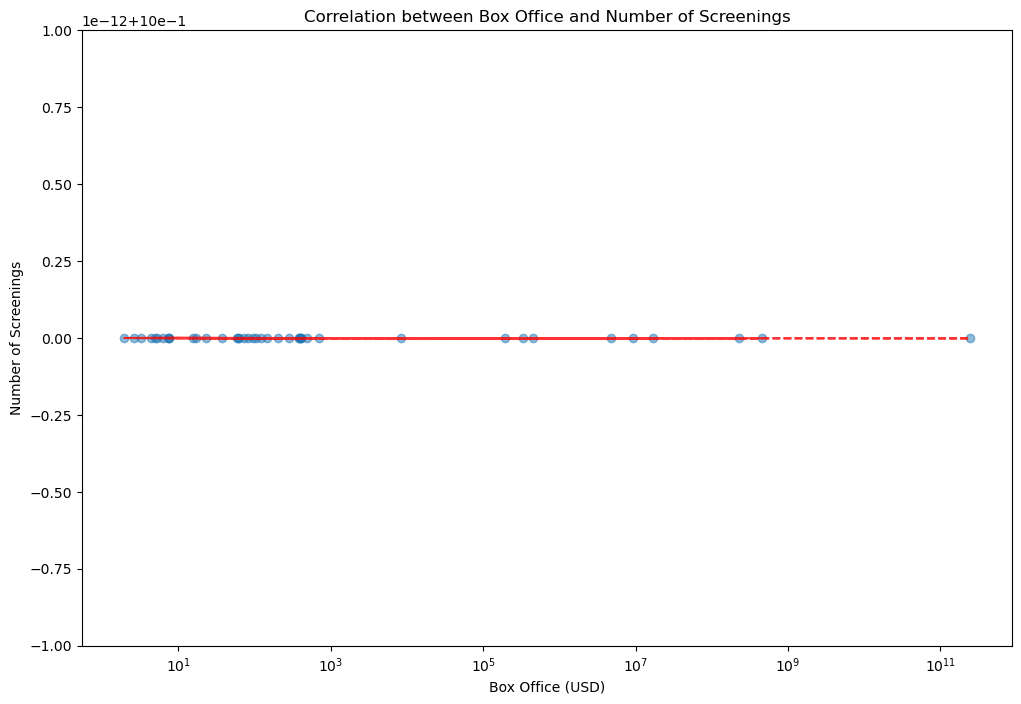

Correlation between box office and number of screenings: nan


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


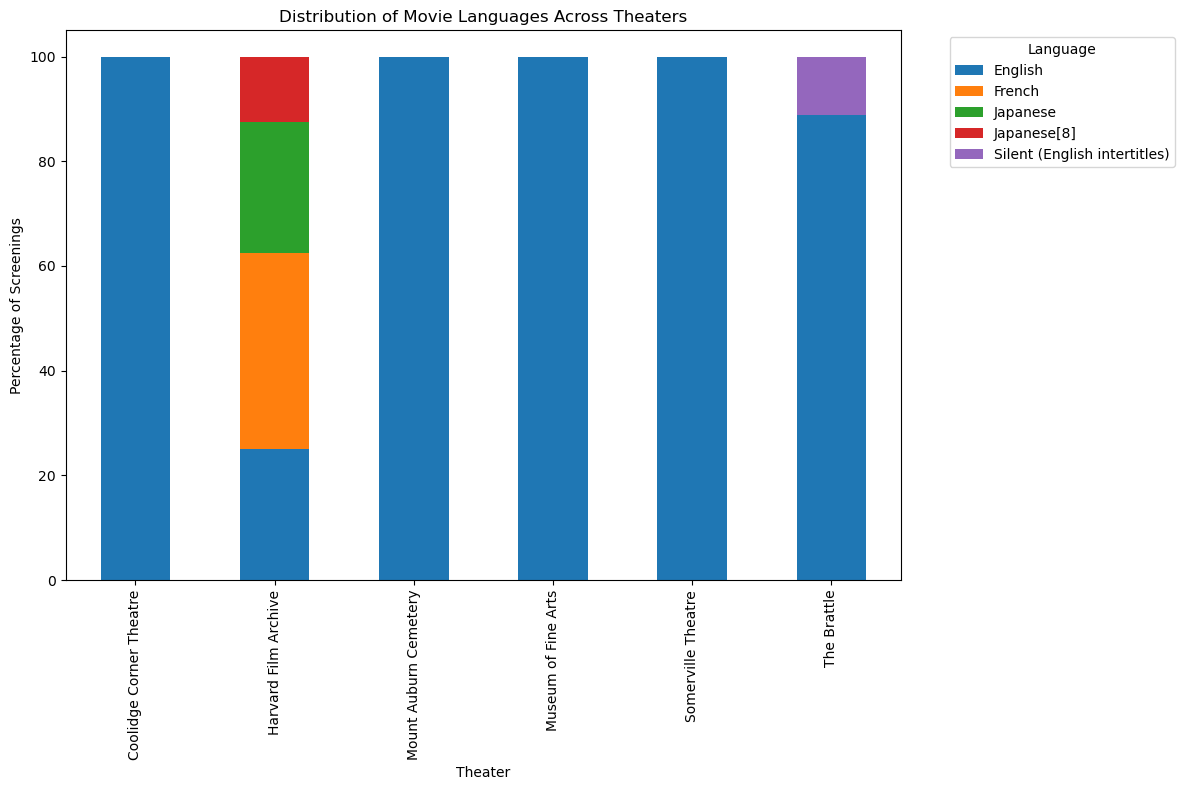


Top 3 languages at Coolidge Corner Theatre:
English: 17 screenings
French: 0 screenings
Japanese: 0 screenings

Top 3 languages at Harvard Film Archive:
French: 3 screenings
English: 2 screenings
Japanese: 2 screenings

Top 3 languages at Mount Auburn Cemetery:
English: 1 screenings
French: 0 screenings
Japanese: 0 screenings

Top 3 languages at Museum of Fine Arts:
English: 1 screenings
French: 0 screenings
Japanese: 0 screenings

Top 3 languages at Somerville Theatre:
English: 9 screenings
French: 0 screenings
Japanese: 0 screenings

Top 3 languages at The Brattle:
English: 8 screenings
Silent (English intertitles): 1 screenings
French: 0 screenings


In [81]:
# 2. Data Analysis and Visualization
# your code here
import matplotlib.pyplot as plt
import numpy as np

# Question 1: Is there a correlation between a movie's box office performance and the number of screenings it gets?

# Remove rows with missing box office data
df_analysis = df_sorted.dropna(subset=['box_office'])

# Group by movie and count screenings
screening_counts = df_analysis.groupby('title').size().reset_index(name='screening_count')

# Merge with box office data
df_analysis = df_analysis.merge(screening_counts, on='title')

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(df_analysis['box_office'], df_analysis['screening_count'], alpha=0.5)
plt.xscale('log')  # Use log scale for box office due to large range
plt.xlabel('Box Office (USD)')
plt.ylabel('Number of Screenings')
plt.title('Correlation between Box Office and Number of Screenings')

# Add trend line
z = np.polyfit(np.log10(df_analysis['box_office']), df_analysis['screening_count'], 1)
p = np.poly1d(z)
plt.plot(df_analysis['box_office'], p(np.log10(df_analysis['box_office'])), "r--", alpha=0.8)

plt.show()

# Calculate correlation
correlation = df_analysis['box_office'].corr(df_analysis['screening_count'])
print(f"Correlation between box office and number of screenings: {correlation:.2f}")

# Question 2: How does the distribution of movie languages vary across different theaters?

# Group by theater and language, count occurrences
language_distribution = df_sorted.groupby(['theater', 'language']).size().unstack(fill_value=0)

# Calculate percentage
language_distribution_pct = language_distribution.div(language_distribution.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
language_distribution_pct.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribution of Movie Languages Across Theaters')
plt.xlabel('Theater')
plt.ylabel('Percentage of Screenings')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print top 3 languages for each theater
for theater in language_distribution.index:
    print(f"\nTop 3 languages at {theater}:")
    top_languages = language_distribution.loc[theater].nlargest(3)
    for lang, count in top_languages.items():
        print(f"{lang}: {count} screenings")

*your answer here*



<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

*your answer here*



In [ ]:
hours_spent_on_hw = ...

: 

In [ ]:
grader.check("wrapup")

: 

In [ ]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

: 

🌈 **This concludes HW1. Thank you!**